In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
import keras
import os
import sys
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
DATA_PATH = "../data/LettuceNPKdataset/FNNPK/"

In [3]:
# Resize image to 1024x1024
def resize_images_in_directory(path):
    for filename in tqdm(os.listdir(path)):
        img = cv.imread(os.path.join(path,filename))
        if img is not None:
            img = cv.resize(img, (1024,1024))
            cv.imwrite(os.path.join(path,filename), img)

for dir_name in os.listdir(DATA_PATH):
    resize_images_in_directory(DATA_PATH + dir_name)

100%|██████████| 12/12 [00:00<00:00, 15.11it/s]


In [4]:
# load data

def load_image(image_id:str):
    image_id = image_id.split('.')[0] if image_id.endswith('.png') else image_id.split('.')[0] if image_id.endswith('.png') else image_id
    file_path = image_id + ".png"
    image = cv.imread(file_path)
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def load_data() -> dict:
    # load data
    data_dir = '../data/LettuceNPKdataset/FNNPK'
    os.chdir(data_dir)
    dir_list = os.listdir()
    dir_list.sort()
    data = dict()
    for dir_name in tqdm(dir_list, desc='Loading data'):
        os.chdir(dir_name)
        image_list = [load_image(x) for x in os.listdir() if x.lower().endswith('.png')]
        # print(dir_name, len(image_list))
        data[dir_name] = image_list
        os.chdir('..')
    os.chdir('../../../main')
    return data

In [5]:
#plot image
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

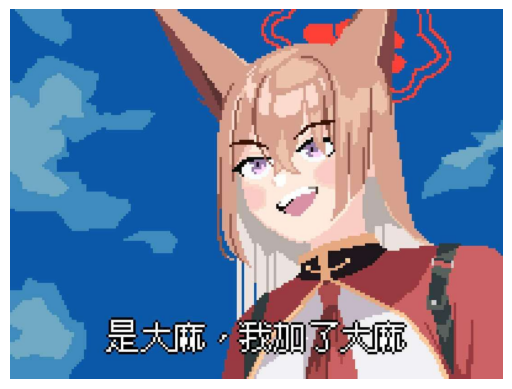

In [6]:
# TEST CODE
test_jpg = load_image('test.png')
plot_image(test_jpg)

In [7]:
# load all data
data = load_data()

Loading data: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


In [8]:
NUM_CLASSES = len(data.keys())
print(f"Number of classes: {len(data.keys())}, Number of images: {sum([len(x) for x in data.values()])}")

Number of classes: 4, Number of images: 208


In [9]:
# normalize data
def normalize_data(data: dict) -> dict:
    return {k: [x/255.0 for x in v] for k, v in data.items()}

nor_data = normalize_data(data)
print(f"Number of classes: {len(data.keys())}, Number of images: {sum([len(x) for x in data.values()])}")

Number of classes: 4, Number of images: 208


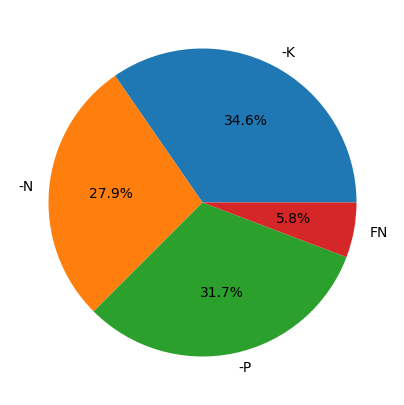

In [10]:
# plot pie chart of data(labels)
def plot_pie_chart(data: dict):
    plt.figure(figsize=(5, 5))
    plt.pie([len(x) for x in data.values()], labels=[x for x in data.keys()], autopct='%1.1f%%')
    plt.show()

def plot_bar_chart_df(data: pd.DataFrame):
    data.plot(kind='pie', subplots=True, figsize=(5, 5))
    plt.show()

plot_pie_chart(nor_data)

In [11]:
df = pd.DataFrame({'image': [x for x in nor_data.values() for x in x], 'label': [x for x in nor_data.keys() for _ in range(len(nor_data[x]))]})
df.head()

,image,label
0,"[[[0.5686274509803921, 0.5215686274509804, 0.4...",-K
1,"[[[0.9372549019607843, 0.9058823529411765, 0.8...",-K
2,"[[[0.9921568627450981, 0.996078431372549, 0.98...",-K
3,"[[[0.8588235294117647, 0.8509803921568627, 0.8...",-K
4,"[[[0.9803921568627451, 0.9803921568627451, 0.9...",-K


In [12]:
# # Data Augmentation for label "FN"
def data_augmentation1(image):
    image = tf.image.flip_left_right(image)
    return image

def data_augmentation2(image):
    image = tf.image.flip_up_down(image)
    return image

df_aug = df[df['label'] == 'FN']
df_aug['image'] = df_aug['image'].apply(data_augmentation1)
df_aug['label'] = 'FN'
df = df.append(df_aug, ignore_index=True)
df_aug = df[df['label'] == 'FN']
df_aug['image'] = df_aug['image'].apply(data_augmentation2)
df_aug['label'] = 'FN'
df:pd.DataFrame = df.append(df_aug, ignore_index=True)

C:\Users\hiban\AppData\Local\Temp\ipykernel_9128\1190534037.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aug['image'] = df_aug['image'].apply(data_augmentation1)
C:\Users\hiban\AppData\Local\Temp\ipykernel_9128\1190534037.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aug['label'] = 'FN'
C:\Users\hiban\AppData\Local\Temp\ipykernel_9128\1190534037.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d

array([<Axes: >], dtype=object)

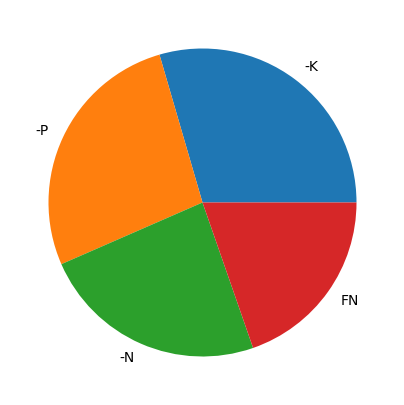

In [13]:
df.value_counts('label', normalize=True).plot(kind='pie', subplots=True, figsize=(5, 5))

In [14]:
# Label Encoding
def label_encoding(label):
    encoder = LabelEncoder()
    label = encoder.fit_transform(label)
    return label, encoder

df['label'], encoder = label_encoding(df['label'])
df.head()

,image,label
0,"[[[0.5686274509803921, 0.5215686274509804, 0.4...",0
1,"[[[0.9372549019607843, 0.9058823529411765, 0.8...",0
2,"[[[0.9921568627450981, 0.996078431372549, 0.98...",0
3,"[[[0.8588235294117647, 0.8509803921568627, 0.8...",0
4,"[[[0.9803921568627451, 0.9803921568627451, 0.9...",0


In [15]:
for i, x in enumerate(encoder.classes_):
    print(f"Class {i}: {x}")

Class 0: -K
Class 1: -N
Class 2: -P
Class 3: FN


In [16]:
# Turn data into tensor and split data
def split_data(data: dict, test_size: float=0.2) -> tuple:
    X = np.array([x for x in data['image']])
    y = np.array([x for x in data['label']])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (195, 1024, 1024, 3), y_train: (195,), X_test: (49, 1024, 1024, 3), y_test: (49,)


In [17]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (195, 1024, 1024, 3), y_train shape: (195,)
X_test shape: (49, 1024, 1024, 3), y_test shape: (49,)


In [18]:
INPUT_SHAPE = X_train[0].shape

In [19]:
# Create model

model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
opt = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()
acc = keras.metrics.SparseCategoricalAccuracy()
model.compile(optimizer=opt, loss=loss, metrics=[acc])
model.summary()

In [20]:
# Train model
EPOCHS = 10
BATCH_SIZE = 32
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

In [21]:
# Plot loss and accuracy

def plot_loss_and_accuracy(history: keras.callbacks.History):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

In [22]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [23]:
# save model
model.save('model.keras')

In [24]:
# save encoder
import pickle
with open('../models/lettuce_npk_encoder.pickle', 'wb') as f:
    pickle.dump(encoder, f)